In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import PIL.Image
import numpy as np
import tqdm

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.nn import init
from matplotlib import pyplot as plt

torch.manual_seed(1)
torch.cuda.manual_seed(1)
PIL.Image.LOAD_TRUNCATED_IMAGES = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

if not os.path.isdir('targetdir/'):
  with zipfile.ZipFile("drive/MyDrive/Data/RealPhotos.zip","r") as zip_ref:
      zip_ref.extractall("targetdir")

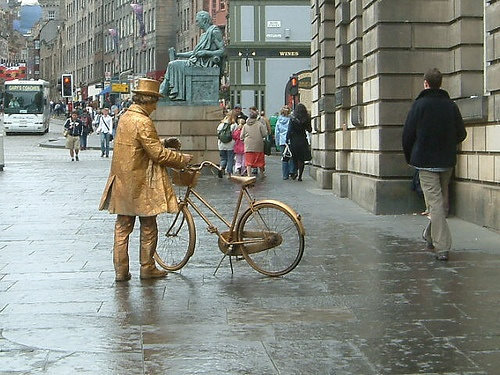

In [4]:
from IPython.display import Image, display
display(Image('targetdir/JPEGImages/2007_000793.jpg', width = 400, height = 400))

In [ ]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 256, 256)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 256, 256)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [ ]:
path = "targetdir/JPEGImages/"
batch_size = 32 

class RealPhotosDataset(Dataset):
    def __init__(self, directory):
        self.files = [os.path.join(directory, f) for f in os.listdir(directory)]

    def __getitem__(self, index):
        img = PIL.Image.open(self.files[index]).convert('RGB')
        img = img.resize((256, 256))
        img = np.array(img) / 255.0
        img = np.transpose(img,(2,0,1)).astype('float32')
        return torch.tensor(img-0.5)
    
    def __len__(self):
      return len(self.files)

data_set = RealPhotosDataset(path)

train_len = int(len(data_set) * 0.9)
train_set, test_set = random_split(data_set, [train_len, len(data_set) - train_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(test_set, batch_size=4, num_workers=5)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ReNetBlock(nn.Module):
    def __init__(self,infil=64,outfil=64):
        super(ReNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(infil, outfil, kernel_size=3, stride=1,padding=1)
        self.bn1 =  nn.InstanceNorm2d(outfil)
        self.relu1 =  nn.ReLU(False)

        self.conv2 = nn.Conv2d(outfil, outfil, kernel_size=3, stride=1,padding=1)
        self.bn2 = nn.InstanceNorm2d(outfil)
        self.relu2 =  nn.ReLU(False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu2(out)

        return out

class ConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=3,strides=2,pad=1):
        super(ConvBNR, self).__init__()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad)
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)))


class TransposeConvBNR(nn.Module):
  def __init__(self,in_channels,out_channels,activation=nn.LeakyReLU(0.2, False),kw=4,strides=2,pad=1):
        super(TransposeConvBNR, self).__init__()
        self.conv1= nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kw, stride=strides,padding=pad)
        self.bn1 =nn.InstanceNorm2d(out_channels, affine=False)
        self.activation = activation
  def forward(self,x):
        return self.bn1(self.conv1(self.activation(x)))


class VAE2_encoder(nn.Module):
    def __init__(self,in_channels=3,n_res_blocks=4,n_layers=5):
        super(VAE2_encoder, self).__init__()
        self.n_layers=n_layers
        self.layer=nn.ModuleList()
        self.layer1 = ConvBNR(in_channels,64,kw=7,pad=3,strides=1)
        for j in range(n_layers):
            self.layer.append(ConvBNR(64,64))

        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        x=self.layer1(x)
        for j in range(self.n_layers):
          x= self.layer[j](x)

        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x)
        return x


class VAE2_decoder(nn.Module):
    def __init__(self,in_channels=64,out_channel=3,n_res_blocks=4,n_layers=5):
        super(VAE2_decoder, self).__init__()
        self.n_layers=n_layers
        self.layer=nn.ModuleList()
        for j in range(n_layers):
            self.layer.append(TransposeConvBNR(64,64,pad=1));

        self.layer1 = nn.Conv2d(64, out_channel, kernel_size=1, stride=1)
        self.res_blks=nn.ModuleList()
        self.n_res_blocks=n_res_blocks
        for j in range(n_res_blocks):
          self.res_blks.append(ReNetBlock(64,64))

    def forward(self, x):
        for j in range(self.n_res_blocks):
           x=self.res_blks[j](x)
        
        for j in range(self.n_layers):
            x= self.layer[j](x)
        x=self.layer1(x)
        return x


class VAE2(nn.Module):
  def __init__(self,z_dim=256):
        super(VAE2, self).__init__()
        self.n_layers=2
        self.down_fact=2**self.n_layers
        down_img_size=256//self.down_fact
        self.fdim=(down_img_size)**2*64
        print('bottle neck image resolution '+str(down_img_size))
        print('bottle neck dim is '+str(self.fdim)+'..!')
        self.size=[64,down_img_size,down_img_size]
        self.encoder=VAE2_encoder(n_layers=self.n_layers)
        self.decoder=VAE2_decoder(n_layers=self.n_layers)
        self.fc1 = nn.Linear(self.fdim, z_dim)
        self.fc2 = nn.Linear(self.fdim, z_dim)
        self.fc3 = nn.Linear(z_dim, self.fdim)

  def flat(self, input):
        return input.view(input.size(0),1, -1)

  def unflat(self, input):
        return input.view(input.size(0), self.size[0], self.size[1], self.size[2])

  def init_weights(self, init_type="xavier", gain=0.02):
      def init_func(m):
          classname = m.__class__.__name__
          if classname.find("BatchNorm2d") != -1:
              if hasattr(m, "weight") and m.weight is not None:
                  init.normal_(m.weight.data, 1.0, gain)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Conv") != -1):
              if init_type == "normal":
                  init.normal_(m.weight.data, 0.0, gain)
              elif init_type == "xavier":
                  init.xavier_normal_(m.weight.data, gain=gain)
              elif init_type == "xavier_uniform":
                  init.xavier_uniform_(m.weight.data, gain=1.0)
              elif init_type == "kaiming":
                  init.kaiming_normal_(m.weight.data, a=0, mode="fan_in")
              elif init_type == "orthogonal":
                  init.orthogonal_(m.weight.data, gain=gain)
              elif init_type == "none":  # uses pytorch's default init method
                  m.reset_parameters()
              else:
                  raise NotImplementedError("initialization method [%s] is not implemented" % init_type)
              if hasattr(m, "bias") and m.bias is not None:
                  init.constant_(m.bias.data, 0.0)
          elif hasattr(m, "weight") and (classname.find("Linear") != -1):
              init.normal_(m.weight.data,0.0,gain)

      self.apply(init_func)
      for m in self.children():
            if hasattr(m, "init_weights"):
                m.init_weights(init_type, gain)
        
  def reparameterize(self, mu, logvar):
      std = logvar.mul(0.5).exp_()
      esp = torch.randn(*mu.size()).to(device)
      z = mu + std * esp  
      return z
  
  def bottleneck(self, h):
      mu, logvar = self.fc1(h), self.fc2(h)
      logvar=logvar * 1e-3 #lazy way to stabilize the training.
      z = self.reparameterize(mu, logvar)
      return z, mu, logvar

  def encode(self, x):
      h = self.encoder(x)
      h=self.flat(h)
      z, mu, logvar = self.bottleneck(h)
      return z, mu, logvar

  def decode(self, z):
      z = self.fc3(z)
      z_img=self.unflat(z)
      z = self.decoder(z_img)
      return z,z_img

  def forward(self, x):
      z, mu, logvar = self.encode(x)
      z,z_out = self.decode(z)
      return z, mu, logvar,z_out

In [ ]:
class ConvBNRelu(nn.Module):
    def __init__(self, nin,nout,stride=2):
        super(ConvBNRelu, self).__init__()
        self.layer=nn.Sequential(nn.Conv2d(in_channels = nin,out_channels = nout,kernel_size = 4,stride = stride,padding = 1,bias = False),
                  nn.BatchNorm2d(nout),
                  nn.LeakyReLU(0.2, inplace=True))
    def forward(self, x):
        return self.layer(x)


class Discriminator(nn.Module):
    def __init__(self,nChannels=64, ndf=64):
        super(Discriminator, self).__init__()
        self.layer1 = ConvBNRelu(nChannels,ndf,stride=2)
        self.layer2 =  ConvBNRelu(ndf,ndf*2,stride=2) 
        self.layer3 =  ConvBNRelu(ndf*2,ndf*4,stride=2)
        self.layer4 =  ConvBNRelu(ndf*4,ndf*8,stride=2)
        self.layer5 =   ConvBNRelu(ndf*8,1,stride=1)
        self.final = nn.Conv2d(in_channels = 1,out_channels = 1,kernel_size = 1,stride = 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out=self.final(out)
        return out

bottle neck image resolution 64
bottle neck dim is 262144..!


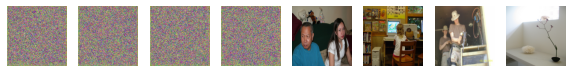

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.2457


Epoch 1: 100%|██████████| 482/482 [05:13<00:00,  1.54batch/s]


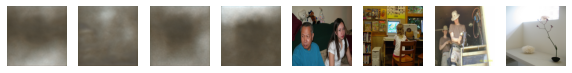

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.1846


Epoch 2: 100%|██████████| 482/482 [05:14<00:00,  1.53batch/s]


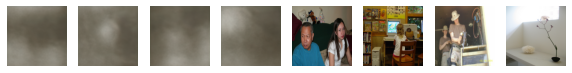

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.1510


Epoch 3: 100%|██████████| 482/482 [05:15<00:00,  1.53batch/s]


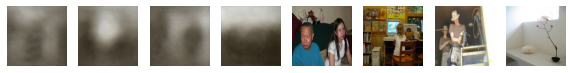

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.1218


Epoch 4: 100%|██████████| 482/482 [05:14<00:00,  1.53batch/s]


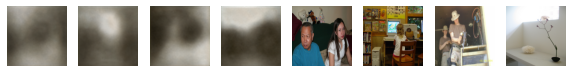

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.1168


Epoch 5: 100%|██████████| 482/482 [05:12<00:00,  1.54batch/s]


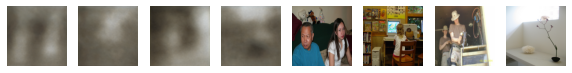

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.1009


Epoch 6: 100%|██████████| 482/482 [05:12<00:00,  1.54batch/s]


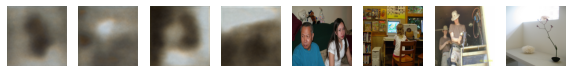

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0858


Epoch 7: 100%|██████████| 482/482 [05:14<00:00,  1.53batch/s]


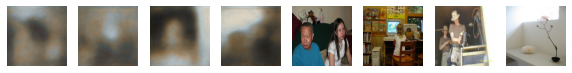

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0805


Epoch 8: 100%|██████████| 482/482 [05:15<00:00,  1.53batch/s]


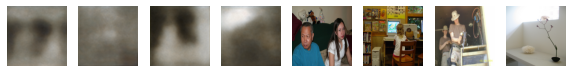

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0824


Epoch 9: 100%|██████████| 482/482 [05:15<00:00,  1.53batch/s]


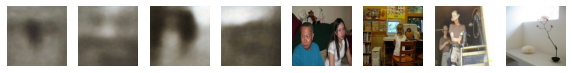

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0778


Epoch 10: 100%|██████████| 482/482 [05:14<00:00,  1.53batch/s]


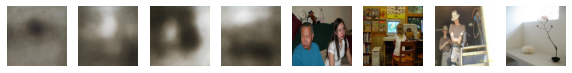

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0767


Epoch 11: 100%|██████████| 482/482 [05:14<00:00,  1.53batch/s]


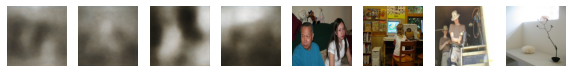

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0770


Epoch 12: 100%|██████████| 482/482 [05:15<00:00,  1.53batch/s]


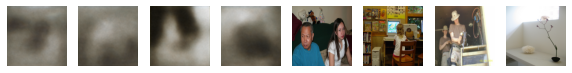

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0763


Epoch 13: 100%|██████████| 482/482 [05:15<00:00,  1.53batch/s]


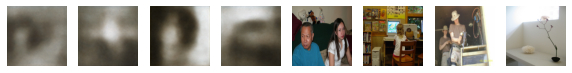

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0756


Epoch 14: 100%|██████████| 482/482 [05:13<00:00,  1.54batch/s]


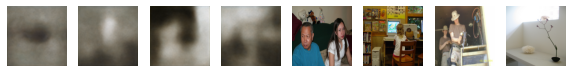

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0755


Epoch 15: 100%|██████████| 482/482 [05:14<00:00,  1.53batch/s]


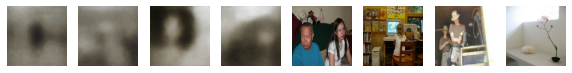

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0756


Epoch 16: 100%|██████████| 482/482 [05:14<00:00,  1.53batch/s]


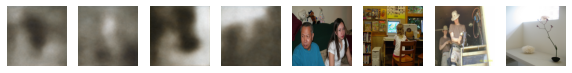

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0752


Epoch 17: 100%|██████████| 482/482 [05:14<00:00,  1.53batch/s]


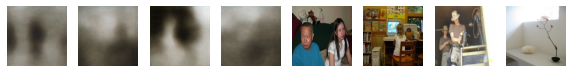

  0%|          | 0/482 [00:00<?, ?batch/s]

====> Test set loss: 0.0751


Epoch 18: 100%|██████████| 482/482 [05:15<00:00,  1.53batch/s]


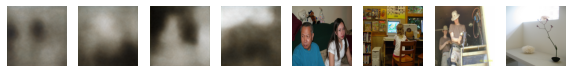

In [ ]:
netG=VAE2().to(device)
netD = Discriminator(nChannels=3,ndf=64).to(device)
learning_rate = 0.001

optD = torch.optim.Adam(
    netD.parameters(),
    lr=learning_rate, betas=(0.5, 0.999)
)
optG = torch.optim.Adam(
    netG.parameters(),
    lr=learning_rate, betas=(0.5, 0.999)
)

epochs = 100
decayRate = 0.999
lrdecay_schedulerD = torch.optim.lr_scheduler.ExponentialLR(optimizer=optD, gamma=decayRate)
lrdecay_scheduleG = torch.optim.lr_scheduler.ExponentialLR(optimizer=optG, gamma=decayRate)


lossL1=torch.nn.L1Loss()
means=[]
logvars=[]

for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        netG.train()
        netD.train()
        with tqdm.tqdm(train_loader, total=int(len(train_loader)), unit="batch",position=0, leave=True) as tepoch:
          for x in tepoch:
              tepoch.set_description(f"Epoch {epoch}")
              x = x.to(device)
              x_hat, mu, logvar,_ = netG(x)
              is_fake_det = netD(x_hat.detach().to(device))
              is_real = netD(x)
              lossD = torch.mean((is_real-1.0)**2+is_fake_det**2)
              optD.zero_grad()
              lossD.backward()
              optD.step()

              is_fake = netD(x_hat)
              loss_GAN = torch.mean((is_fake-1.0)**2)
              loss_l1=lossL1(x_hat, x)*10.0
              loss_kl=0.5 * torch.mean(logvar.exp() - logvar - 1.0 + mu**2)
              lossG=loss_GAN+loss_l1+loss_kl
              optG.zero_grad()
              lossG.backward()

              optG.step()
              lrdecay_schedulerD.step()
              lrdecay_scheduleG.step()
    
    # Testing
    with torch.no_grad():
        netG.eval()
        test_loss = 0.0
        for ix,x in enumerate(test_loader):
            x = x.to(device)
            x_hat, mu, logvar,_ = netG(x)
            loss=0.0
            loss+=lossL1(x_hat, x)
            loss+=0.5 * torch.mean(logvar.exp() - logvar - 1.0 + mu**2)

            test_loss+=loss.item()
            if(ix<1):
              plt.figure(figsize=(10, 4))
              for i in range(4):
                  plt.subplot(1,8,i+1)
                  plt.imshow(np.clip(x_hat.detach().cpu().numpy()[i,:,:,:].transpose(1,2,0)+0.5,0.0,1.0))
                  plt.axis('off')

              for i in range(4):
                  plt.subplot(1,8,i+1+4)
                  plt.imshow(np.clip(x.detach().cpu().numpy()[i,:,:].transpose(1,2,0)+0.5,0.0,1.0))
                  plt.axis('off')
              plt.show()

    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    #display_images(x, x_hat, 1, f'Epoch {epoch}')